#SISTEMA DE FRENADO:

En situaciones donde las decisiones son críticas lo mejor son los sistemas basados en reglas. En nuestro caso, no desarrollaremos uno, sino que lo tendremos en mente para desarrollar un método que en base a una imagen segmentada, analizará las características de dicha segmentación, y devolverá una decisión: el vehículo debe frenar o no debe frenar.

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import cv2
import numpy as np
import itertools
import matplotlib.pyplot as plt
from keras import layers, Model, models, callbacks, applications
from tensorflow_probability import layers as tfp_layers

In [ ]:
train_data = np.load('/content/drive/MyDrive/TFG/data3/train_data.npy')
train_label = np.load('/content/drive/MyDrive/TFG/data3/train_label.npy')
val_data = np.load('/content/drive/MyDrive/TFG/data3/val_data.npy')
val_label = np.load('/content/drive/MyDrive/TFG/data3/val_label.npy')
test_data = np.load('/content/drive/MyDrive/TFG/data3/test_data.npy')
test_label = np.load('/content/drive/MyDrive/TFG/data3/test_label.npy')

In [ ]:
data_shape = 256*512  # Nueva resolución de las imágenes (originalmente 1024x2048)
label_colors = {
    "unlabeled": [0, 0, 0],
    "ego vehicle": [0, 0, 0],
    "rectification border": [0, 0, 0],
    "out of roi": [0, 0, 0],
    "static": [0, 0, 0],
    "dynamic": [111, 74,  0],
    "ground": [81,  0, 81],
    "road": [128, 64,128],
    "sidewalk": [244, 35,232],
    "parking": [250,170,160],
    "rail track": [230,150,140],
    "building": [70, 70, 70],
    "wall": [102,102,156],
    "fence": [190,153,153],
    "guard rail": [180,165,180],
    "bridge": [150,100,100],
    "tunnel": [150,120, 90],
    "pole": [153,153,153],
    "polegroup": [153,153,153],
    "traffic light": [153,153,153],
    "traffic sign": [250,170, 30],
    "vegetation": [107,142, 35],
    "terrain": [152,251,152],
    "sky": [70,130,180],
    "person": [220, 20, 60],
    "rider": [255, 0, 0],
    "car": [ 0,  0,142],
    "truck": [0,  0, 70],
    "bus": [ 0, 60,100],
    "caravan": [ 0,  0, 90],
    "trailer": [ 0,  0,110],
    "train": [ 0, 80,100],
    "motorcycle": [0,  0,230],
    "bicycle": [119, 11, 32],
    "license plate": [0,0,142]
}
reduced_label_colors = {
    "background": [46,0,137],  # Azul oscuro
    "vehicle": [255, 255, 0],  # Amarillo
    "person": [255, 0, 0],  # Rojo
    "road": [128, 128, 128]  # Gris
}
num_classes = 4

In [ ]:
color_array = np.array(list(reduced_label_colors.values()))
def visualize(temp, plot=False):
    temp = np.argmax(temp, axis=-1).reshape((256,512))
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()

    for l in range(len(color_array)):
        r[temp == l] = color_array[l, 0]
        g[temp == l] = color_array[l, 1]
        b[temp == l] = color_array[l, 2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0

    if plot:
        plt.imshow(rgb)
    else:
        return rgb

Cargamos el modelo de MC Dropout óptimo:

In [ ]:
def build_segnet2(input_shape=(256, 512, 3), num_classes=4, droprate=0.5):
    # Cargar VGG16 sin las capas fully connected
    vgg16 = applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    inputs = vgg16.input
    x = vgg16.layers[1](inputs)

    i = -6
    for layer in vgg16.layers[2:]:
        x = layer(x)
        # Agregar Dropout en los últimos 3 bloques del encoder
        if 'pool' in layer.name and i >= 0:
            x = layers.Dropout(droprate)(x, training=True)
        i += 1

    # Decoder
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.Dropout(droprate)(x, training=True)

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.Dropout(droprate)(x, training=True)

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Dropout(droprate)(x, training=True)

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(x)

    # Crear el modelo completo
    model = models.Model(inputs, outputs, name='Custom_SegNet_MCDrop')

    return model

# Crear y mostrar el modelo
model_mcdrop = build_segnet2()
model_mcdrop.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "Custom_SegNet_MCDrop"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 512, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 512, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 256, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 256, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 128, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 128, 256)   │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 128, 256)   │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 128, 256)   │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 64, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 64, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 64, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 16, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 16, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 32, 512)    │     2,359,80

 Total params: 31,750,276 (121.12 MB)

 Trainable params: 31,750,276 (121.12 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_mcdrop.load_weights("/content/drive/MyDrive/TFG/weights/visualizar/Modelo_MCDROP_Mas_Datos_PesosMediosFinal.weights.h5")

In [ ]:
@tf.function
def mc_dropout_inference2(model, x, num_samples=10):
    predictions = tf.stack([model(x, training=True) for _ in range(num_samples)])
    return predictions, tf.reduce_mean(predictions, axis=0), tf.math.reduce_variance(predictions, axis=0)

In [ ]:
# Constantes
CAR_CLASS = 1
PEDESTRIAN_CLASS = 2
UNCERTAINTY_THRESHOLD = 0.2
ROAD_CLASS = 3

Método que recibe una imagen segmentada, y devuelve el vector de características asociado:

In [ ]:
from skimage.measure import label, regionprops

def extract_features(mean_pred, var_pred):
    class_map = tf.argmax(mean_pred, axis=-1).numpy()       # [H, W]
    uncertainty_map = tf.reduce_max(var_pred, axis=-1).numpy()
    H, W = class_map.shape

    mask_peds = (class_map == PEDESTRIAN_CLASS)
    mask_road = (class_map == ROAD_CLASS)

    labeled_peds = label(mask_peds)
    props = regionprops(labeled_peds)

    total_area = 0
    widths = []
    heights = []
    x_positions = []
    distances = []
    crossing_peds = 0
    high_unc_nearby = 0
    total_uncertainty = []
    ped_close = 0
    road_pixels = np.sum(mask_road)

    for reg in props:
        y0b, x0b, y1b, x1b = reg.bbox
        height = y1b - y0b
        width = x1b - x0b
        bottom_y = y1b
        dist_norm = 1 - (bottom_y / H)
        mask = (labeled_peds == reg.label)

        mean_unc = np.mean(uncertainty_map[mask])
        on_road = np.any(mask_road[y1b:min(y1b+2, H), x0b:x1b])
        is_crossing = width > height
        is_close = dist_norm < 0.3
        high_unc = mean_unc > UNCERTAINTY_THRESHOLD

        if on_road:
            total_area += reg.area
            widths.append(width / W)
            heights.append(height / H)
            x_positions.append(reg.centroid[1])
            distances.append(dist_norm)
            total_uncertainty.append(mean_unc)

            if is_crossing:
                crossing_peds += 1
            if is_close:
                ped_close += 1
                if high_unc:
                    high_unc_nearby += 1

    blocking_mask = (mask_peds & mask_road)
    blocking_ratio = np.sum(blocking_mask) / road_pixels if road_pixels > 0 else 0

    return {
        "num_peds_on_road": len(distances),
        "num_peds_very_close": ped_close,
        "min_dist_norm": min(distances) if distances else 1,
        "avg_ped_area_on_road": total_area / road_pixels if road_pixels else 0,
        "mean_unc_peds_on_road": np.mean(total_uncertainty) if total_uncertainty else 0,
        "num_high_uncertainty_nearby": high_unc_nearby,
        "num_crossing_peds": crossing_peds,
        "max_ped_width_ratio": max(widths) if widths else 0,
        "ped_blocking_ratio": blocking_ratio,
        "std_x_pos_peds": np.std(x_positions) if x_positions else 0,
        "avg_ped_width_ratio": np.mean(widths) if widths else 0,
    }


Sistema de frenado: recibe el vector de características de la imágen, y devuelve si debe frenar el vehículo o no:

In [ ]:
def should_brake(features):
    # Ponderaciones ajustables
    W_CLOSE_PEDS         = 0.6
    W_DIST               = 0.4
    W_BLOCKING           = 0.5
    W_CROSSING           = 0.2
    W_UNCERTAINTY        = 0.2
    W_SPREAD             = 0.2
    W_AREA               = 0.4

    danger_score = 0

    # Proporcional al número de peatones muy cerca (normalizado con 3)
    danger_score += W_CLOSE_PEDS * min(1.0, features["num_peds_very_close"] / 3)

    # Penaliza peatones muy cercanos (cuanto más cerca, más peligro)
    danger_score += W_DIST * max(0, (0.4 - features["min_dist_norm"]) / 0.4)

    # Cuánto de la carretera está bloqueada
    danger_score += W_BLOCKING * features["ped_blocking_ratio"]

    # Penaliza si hay muchos peatones cruzando
    danger_score += W_CROSSING * min(1.0, features["num_crossing_peds"] / 2)

    # Penaliza si hay mucha incertidumbre cerca
    danger_score += W_UNCERTAINTY * min(1.0, features["num_high_uncertainty_nearby"] / 2)

    # Si están dispersos horizontalmente, probablemente cruzan desde distintos lados
    danger_score += W_SPREAD * features["std_x_pos_peds"]

    # Si ocupan mucha área de la carretera
    danger_score += W_AREA * features["avg_ped_area_on_road"]

    # Decisión final
    return int(danger_score >= 0.7)

Método que recibe el dataset, lo pasa a través del modelo de MC Dropout, y extrae las características de la segmentación devuelta por el modelo, pasa dichas características al sistema de frenado, y en base a la decisión que nos dé, la almacena con su etiqueta correspondiente:

In [ ]:
def process_dataset_with_uncertainty_and_labels(model, dataset, num_samples=10):
    feature_list = []
    label_list = []

    for x in tqdm(dataset, desc="Procesando dataset"):
        if len(x.shape) == 3:
            x = tf.expand_dims(x, axis=0)

        predictions, mean_pred, var_pred = mc_dropout_inference2(model, x, num_samples)

        mean_pred_np = mean_pred[0].numpy()
        var_pred_np = var_pred[0].numpy()

        features = extract_features(mean_pred_np, var_pred_np)
        feature_vector = np.array(list(features.values()), dtype=np.float32)
        label = int(should_brake(features))  # Convertir a 0 o 1

        feature_list.append(feature_vector)
        label_list.append(label)

    X = np.stack(feature_list)
    y = np.array(label_list, dtype=np.int32)
    return X, y


In [ ]:
train_features, train_labels = process_dataset_with_uncertainty_and_labels(model_mcdrop, train_data[:1000], num_samples=10)

Procesando dataset: 100%|██████████| 1000/1000 [07:37<00:00,  2.19it/s]


In [ ]:
np.save('/content/drive/MyDrive/TFG/Cityscapes/train_features_1000_auto2.npy', train_features)
np.save('/content/drive/MyDrive/TFG/Cityscapes/train_labels_1000_auto2.npy', train_labels)

In [ ]:
train_features = np.load('/content/drive/MyDrive/TFG/Cityscapes/train_features_1000_auto2.npy')
train_labels = np.load('/content/drive/MyDrive/TFG/Cityscapes/train_labels_1000_auto2.npy')

In [ ]:
train_labels.sum()

np.int64(200)

In [ ]:
train_features[0]

array([2.00000000e+00, 0.00000000e+00, 5.00000000e-01, 4.49346565e-02,
       1.48678673e-02, 0.00000000e+00, 2.00000000e+00, 1.46484375e-01,
       0.00000000e+00, 5.20791817e+01, 1.03515625e-01], dtype=float32)

In [ ]:
# Indices donde la etiqueta es 1
indices_con_freno = [i for i, label in enumerate(train_labels) if label == 1]

for idx in indices_con_freno:
    plt.imshow(visualize(train_label[idx]))  # Suponiendo que train_dataset[idx] es la imagen original
    plt.title(f"Etiqueta = {train_labels[idx]} (Index: {idx})")
    plt.axis('off')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def plot_segmentation_with_decision(input_image, segmentacion, should_brake):
    """
    Muestra la imagen de entrada, la máscara de segmentación y la segmentación dada por el modelo

    Parámetros:
        input_image (np.ndarray): Imagen de entrada (H x W x 3).
        segmentation_mask (np.ndarray): Máscara de segmentación (H x W) con etiquetas por píxel.
        should_brake (bool): True si el coche debería frenar, False en caso contrario.
    """
    _, mean_pred, _ = mc_dropout_inference2(model_mcdrop, np.expand_dims(input_image, axis=0), num_samples=10)
    # Crea el título de decisión

    # Dibuja los tres paneles
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(input_image)
    plt.title("Ejemplo imagen Frenado")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(visualize(segmentacion))
    plt.title("Segmentación real")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(visualize(mean_pred))
    plt.title("Segmentación modelo MC Dropout")

    plt.tight_layout()
    plt.show()
    print("¿El coche debería frenar?", "Sí" if should_brake else "No")

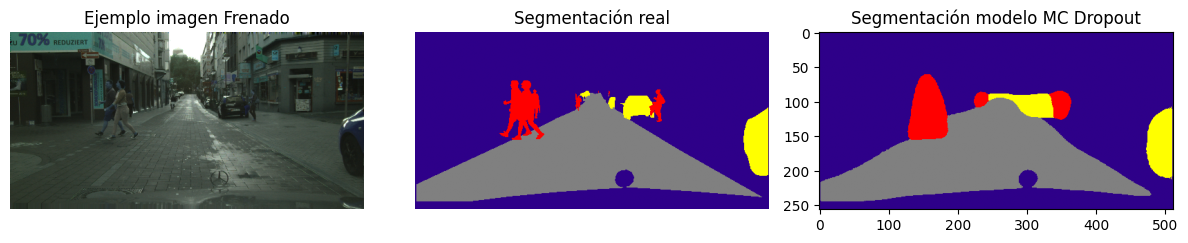

In [ ]:
plot_segmentation_with_decision(train_data[690],train_label[690], train_labels[690])